<h1>Table of content</h1>
<br>
<ol>
<li><a href="#Data">Data</a></li>
<li><a href="#libraries">Libraries</a></li>
<li><a href="#Utils">Utils</a></li>
<li><a href="#PreProcessing">Preprocessing(including parts of section D)</a></li>
<li><a href="#Section A">Section A</a></li>
<li><a href="#Section B">Section B</a></li>
<li><a href="#Section C">Section C</a></li>
</ol>

<h1 id="Data">Data</h1>
<p>
The data consists of features of real estate in different areas of Bangalore. It
was pre-processed for convenience.<br>
Variables:<br>
• availability: is the property available immediately (1) or in the near<br>
future (0).<br>
• total_sqft: the area of the property in square feet (1 foot = 30.54 cm).<br>
• bedrooms: the number of bedrooms in the property.<br>
• bath: the number of bathrooms in the property.<br>
• balcony: the number of balconies in the property.<br>
• rank: the ranking of the neighborhood in terms of average price (1 is<br>
the highest).<br>
• area_type: is the property type a built up area (B) or plot area (P).<br>
• price in rupees: the price of the property.<br>
</p>

<h2>Tasks</h2>
<p>1. Classification: Use both models from section A and predict the area<br>
type (B, P), using all the features in the dataset.<br>
2. Regression: Use the decision tree model from section A and predict the<br>
price of a property, using all the features in the dataset.<br></p>

<h1 id="libraries">importing Libraries</h1>
<p>Libraries for data visualization, data manipulation and building trees</p>

In [1]:
import numpy
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
# decision tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# random forest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# model building
from sklearn.model_selection import train_test_split, GridSearchCV

# model evaluation
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn import metrics as met
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

#deal with imbalance data classes
from collections import Counter
import imblearn
from imblearn.over_sampling import SMOTE
# adaboost
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor

# gradient boosting
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

# model building
from sklearn.model_selection import train_test_split, GridSearchCV

# model evaluation
from sklearn.metrics import accuracy_score, mean_squared_error

#for log's calculations
import math

from math import e
import random
import time
import warnings
warnings.filterwarnings("ignore")

# set seed for reproducible results
RSEED = 10

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)
pd.options.display.max_columns=300

pd.set_option('display.float_format', lambda x: '%.6f' % x)

<h1 id="Utils">utils functions</h1>
<p>utils functions for our loading and evaluating of the decisions trees<br>
and the AdaBoost (classifier) algorithm
</p>

<h2>Evaluation Metrics</h2>
<h3>Classification</h3>
<p>
Terms:
we chose class B to be our positive and P to be the negative.<br>
therefor in our dataset:<br>
TP = when the model predicted B and its also the real area type of the sample<br>
TN = when the model predicted P and its also the real area type of the sample<br>
FP = when the model predicted B but the real area type of the sample is P<br>
FN = when the model predicted P but the real area type of the sample is B<br>
</p><br><br>
$\large Accuracy    = \dfrac{TP+TN}{TP+TN+FP+FN}$<br><br>
$\large Sensitivity = \dfrac{TP}{TP+FN}$<br><br>
$\large Specificity = \dfrac{TN}{TN+FP}$<br><br>
$\large Precision   = \dfrac{TP}{TP+FP}$<br><br>

<h3>Regression</h3>
<p>
we chose to use MSE as our way to evaluate the regression modules.<br>
let N be num of the testing samples, Y the true value of the Y label and $\hat{Y}$ be our prediction value for a certain sample, therefor:<br><br>
$\large MSE = \sum_{n=0}^{N} \dfrac{(Y- \hat{Y})^2}{N}$
</p>

In [2]:
#load csv file  as dataframe
def load_data():
    real_estate_df = pd.read_csv('data.csv')
    return real_estate_df


#compute evaluate metrics
def calcMatrics(TA,TB,FA,FB):
    accuracy = (TA + TB)/(TA + TB + FA + FB)
    sensitivity = TA / (TA + FB)
    specificity = TB/(TB + FA)
    precision = TA/(TA + FA)
    return accuracy, sensitivity, specificity, precision

#return exp with base e of a given number
def exp(num):
    return e**num

#evaluate a classify module
class Evaluation:

    def __init__(self):
        self.TA = 0
        self.TB = 0
        self.FA = 0
        self.FB = 0
        self.accuracy = 0
        self.sensitivity = 0
        self.specificity = 0
        self.precision = 0

    #calculate evaluate metrics
    def predicting(self,df,tree):
        for i in range(0,len(df.index)):
            # This line below put predicted value for the given sample in #prediction variable
            prediction = tree.predict(tree.root,df.iloc[i])
            #count TP TN
            if df.iloc[i][classify_y] == prediction:
                if df.iloc[i][classify_y] == 'B':
                    self.TA+=1
                else:
                    self.TB +=1
            #count FP FN
            else:
                if prediction == 'B':
                    self.FA+=1
                else:
                    self.FB +=1
        #calc metrics
        self.accuracy, self.sensitivity, self.specificity, self.precision = calcMatrics(self.TA,self.TB,self.FA,self.FB)

#evaluate a classify adaboost module
class AdaEvaluation:

    def __init__(self):
        self.TA = 0
        self.TB = 0
        self.FA = 0
        self.FB = 0
        self.accuracy = 0
        self.sensitivity = 0
        self.specificity = 0
        self.precision = 0

    #calculate evaluate metrics
    def predicting_adaboost(self, df, adaboost):
        for i in range(0,len(df.index)):
            # prediction is the predicted valur by Adaboost of the given sample
            prediction = adaboost.predict(df.iloc[i])
            #count TP TN
            if df.iloc[i][classify_y] == prediction:
                if df.iloc[i][classify_y] == 'B':
                    self.TA+=1
                else:
                    self.TB +=1
            #count FP FN
            else:
                if prediction == 'B':
                    self.FA+=1
                else:
                    self.FB +=1
        #calc metrics
        self.accuracy, self.sensitivity, self.specificity, self.precision = calcMatrics(self.TA,self.TB,self.FA,self.FB)

#evalutae regressor tree
class Reg_Evaluation:

    def __init__(self):
        self.total_Num = 0
        self.sum_ssr = 0
        self.mse = 0
    #calculate evaluate metric
    def predicting_regression(self, df, tree):
        self.total_Num = len(df)
        list_to_return = list()
        mean = df.loc[:,'price in rupees'].values.mean()
        for i in range(0,len(df.index)):
            # prediction is the predicted value by regression tree of the given sample
            prediction = tree.predict(tree.root,df.iloc[i])
            prediction = exp(prediction)
            list_to_return.append(prediction)
            self.sum_ssr += (df.iloc[i][regressor_y] - prediction)**2
        self.mse = self.sum_ssr/self.total_Num
        return list_to_return
#evalutae gradiant boost
class GradiantEvaluation:

    def __init__(self):
        self.mse = 0

    #calculate evaluate metric
    #regressor_test = test dataset
    def predicting_gradiant(self, regressor_test, gradiantboost):
        list_to_return = list()
        for i in range(0,len(regressor_test.index)):
            #prediction  = Reg_Prediction variable
            prediction = gradiantboost.predict(regressor_test.iloc[i])
            prediction = exp(prediction)
            list_to_return.append(prediction)
            self.mse+=(regressor_test.iloc[i][7]- prediction)**2

        self.mse = self.mse/len(regressor_test.index)
        return list_to_return
def gradiant_grid_search(train_data, validation_data, max_depth_list, estimet_num_list,learning_rate):

    gradiant_to_return = None
    min_mse = float('inf')

    #pre- processing for predicting
    eval = GradiantEvaluation()

    #pre-processing the test data(changing categorical values and taking care of skewed feature)
    regressor_validate_area_type = validation_data['area_type'].map({'B': 1, 'P': 0})
    regressor_validation = pd.concat([regressor_validate_area_type, validation_data.iloc[:,2:]], axis=1)
    #validate_log_resp = np.log(validation_data.iloc[:,8:])
    #regressor_validation['price in rupees'] = validate_log_resp

    for depth in max_depth_list:
        for num in estimet_num_list:
            gradiant = GradiantBoost(train_data,learning_rate,depth,num,regressor_y,8,'price in rupees',30,9)
            print("building gradiant boost started...")
            start_time = time.time()
            gradiant.fit()
            print("building gradiant boost ended in %s seconds" % (time.time() - start_time))
            eval.predicting_gradiant(regressor_validation, gradiant)
            if eval.mse < min_mse:
                gradiant_to_return = gradiant
                min_mse = eval.mse
    return gradiant_to_return


#testing different combination of hyperparameters and return the reg tree who operate the best
#on the validation data
def reg_grid_search(train_data, validation_data, max_depth_list, min_samp_list):

    tree_to_return = None
    min_mse = float('inf')

    #pre- processing for predicting
    eval = Reg_Evaluation()

    #pre-processing the test data(changing categorical values and taking care of skewed feature)
    regressor_validate_area_type = validation_data['area_type'].map({'B': 1, 'P': 0})
    regressor_validation = pd.concat([regressor_validate_area_type, validation_data.iloc[:,2:]], axis=1)
    #validate_log_resp = np.log(validation_data.iloc[:,8:])
    #regressor_validation['price in rupees'] = validate_log_resp

    for depth in max_depth_list:
        for min_sample in min_samp_list:
            regTree = RegressionTree(train_data,depth,min_sample,regressor_y)
            print("building regression tree started...")
            start_time = time.time()
            regTree.build(regTree.root)
            print("building regression tree ended in %s seconds" % (time.time() - start_time))
            eval.predicting_regression(regressor_validation, regTree)
            if eval.mse < min_mse:
                tree_to_return = regTree
                min_mse = eval.mse
    return tree_to_return


#testing different combination of hyperparameters and return the classification tree who operate the best
#on the validation data
def classify_grid_search(train_data, validation_data, max_depth_list, min_samp_list):

    classify_validation = validation_data.copy(deep=True)
    classify_validation = classify_validation.drop(['Unnamed: 0'], axis=1)

    max_accuracy = 0
    tree_to_return = None

    eval = Evaluation()
    for depth in max_depth_list:
        for min_samp in min_samp_list:
            classify_tree = ClassifyTree(train_data,depth,min_samp)
            print("building classify tree started...")
            start_time = time.time()
            classify_tree.build(classify_tree.root)
            print("building classify tree ended in %s seconds" % (time.time() - start_time))
            eval.predicting(classify_validation,classify_tree)

            if eval.accuracy > max_accuracy:
                max_accuracy = eval.accuracy
                tree_to_return = classify_tree

    return tree_to_return

#testing different combination of hyperparameters and return the adaboost who operate the best
#on the validation data
def adaboost_grid_search(train_data, validation_data, estimators_num):

    classify_validation = validation_data.copy(deep=True)
    classify_validation = classify_validation.drop(['Unnamed: 0'], axis=1)

    max_specificity = 0
    adaboost_to_return = None

    eval = AdaEvaluation()
    for num in estimators_num:
        classify_adaboost = AdaBoost(train_data,num)
        classify_adaboost.fit()
        AdaEvaluation()
        eval.predicting_adaboost(classify_validation, classify_adaboost)
        if eval.specificity > max_specificity:
            max_specificity = eval.specificity
            adaboost_to_return = classify_adaboost

    return adaboost_to_return

<h1 id="PreProcessing">Pre Processing</h1>

<h2>loading and splitting the dataset</h2>

In [3]:
#loading data
real_estate_df = load_data()
#spliting data
train = real_estate_df.iloc[0:8040]
validation = real_estate_df.iloc[8040:10050]
test = real_estate_df.iloc[10050:12563]

<h2>Define X,Y features</h2>


In [4]:

#x features for classification tree
classify_x = [1,2,3,4,5,6,7]

#label index for classification tree
classify_y = 0

#area_type values our classification values
classes = ['B','P']

#split classify features to categorical and numeric
categoricals_list = [1]
numeric_list = [2,3,4,5,6,7]

#x features for regressor
regressor_x = [0,1,2,3,4,5,6]

#label index for regressor
regressor_y = 7

#x, y data for regressor
regressor_train_X = train.iloc[:,1:8] #dataframe excluding price in rupees column
regressor_train_y = train.iloc[:,8:]  #price in rupees column
#change values of area type to numeric
regressor_train_area_type = regressor_train_X['area_type'].map({'B': 1, 'P': 0})
regressor_train_X = pd.concat([regressor_train_area_type, regressor_train_X.iloc[:,1:]], axis=1)
#regressor_new_train = the regressor train dataset after replacing B, P  to 1,0(including price in rupees column)
regressor_new_train = pd.concat([regressor_train_X, regressor_train_y], axis=1)

#lists of x features indexes for the regression model
reg_categoricals_list = [0,1]
reg_numeric_list = [2,3,4,5,6]

<h2>Hyper parameters</h2>

In [5]:
#max depth of the tree
max_depth = [4,7]

reg_max_depth = [8,9]

#min samples per node
min_samples = [2,4]

reg_min_samples = [20,30]

#num of stumps
n_estimators = [2,20]

#learning rate
learning_rate = 0.5

#max leafs
gradiant_max_depth = [4,5]

#max estimators
gradiant_estimators = [10,20]


<h2>examining the dataset</h2>

<h3>quick view<h3>
<p>
First we will examine our data and look for any problems in it that might reduced the accurecy of our modules.
</p>

In [6]:
real_estate_df.head()

,Unnamed: 0,area_type,availability,bedrooms,total_sqft,bath,balcony,ranked,price in rupees
0,0,B,1,3.000000,1655.000000,3.000000,1.000000,134,10800000.000000
1,1,B,1,2.000000,1102.000000,2.000000,1.000000,134,4800000.000000
2,2,B,0,2.000000,1112.000000,2.000000,1.000000,242,8800000.000000
3,3,B,1,3.000000,1450.000000,3.000000,3.000000,335,5100000.000000
4,4,B,1,2.000000,1010.000000,2.000000,1.000000,261,4100000.000000


In [7]:
real_estate_df.iloc[:,1:].dtypes

area_type           object
availability         int64
bedrooms           float64
total_sqft         float64
bath               float64
balcony            float64
ranked               int64
price in rupees    float64
dtype: object

<p>As we can see our data contains 8 features (2 categorial and 6 numeric) and also an unnamed colloumn that does not releveat <br>so we will remove it.</p>
<br>
<h2>Shape</h2>

In [8]:
real_estate_df.shape

(12563, 9)

<h2>Data statistics</h2>
<p>we will cheack the statistic(mean, median, std, min, max..etc)<br>
of our dataset in order learn more about the distribution and more about each  numeric feature</p>

In [10]:
real_estate_df.iloc[:,3:].describe()

,bedrooms,total_sqft,bath,balcony,ranked,price in rupees
count,12563.000000,12563.000000,12563.000000,12563.000000,12563.000000,12563.000000
mean,2.741145,1794.519223,2.617607,1.602165,236.386054,10630074.026904
std,1.204731,14702.309017,1.221164,0.804165,120.749788,13226952.461002
min,1.000000,250.000000,1.000000,0.000000,1.000000,800000.000000
25%,2.000000,1100.000000,2.000000,1.000000,134.000000,4950000.000000
50%,3.000000,1260.000000,2.000000,2.000000,226.000000,7000000.000000
75%,3.000000,1641.500000,3.000000,2.000000,335.000000,11500000.000000
max,43.000000,1306800.000000,40.000000,3.000000,504.000000,291200000.000000


<p>As we can see there is a huge different between the mean the median and even the 75% and the max value of our<br>
regressor label(price in rupees), what that can point out the the feature is skewed or that it has outliers,<br>
there for we will create a histogram of this feature to learn more.<br>
the bedrooms and bath features has very close statistics values so there may be high correlation between them.<br>
we will create a heatmap of the correlation of each pairs to learn more.</p>

<h3>checking correlation</h3>

<AxesSubplot:title={'center':'correlation of the features'}>

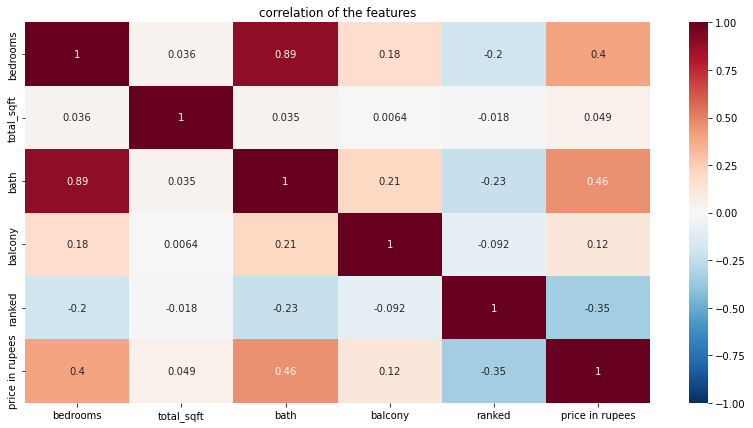

In [11]:
plt.figure(figsize=(14,7))
plt.title("correlation of the features")
heatmap_data = real_estate_df.iloc[:, 3:].corr()
sns.heatmap(data=heatmap_data,cmap= 'RdBu_r', vmin=-1, vmax=1, annot=True)

<p>As we can see there is a very high correlation between bedrooms number and the baths number<br>
typically we would remove one of them becaues their are basically different measurements of the same thing<br>
 but in this assigment we were told to use all the feature for classification and regression.</p>

<h2>checking for missing values</h2>
<br>
<p>we need to check if there are any missing values in our data<br>
if there are so some of the models(escpecilly sklearns) will freak out.<br>
there are 2 methods for handelig missing values:<br>
<ol>
<li>remove the samples with missing values(good if the part of the missing samples is small or if or most of the features in the sample are missing)</li><br>
<li>various imputation methods.</li>
</il>
</p>

In [12]:
real_estate_df.iloc[:,1:].isnull().sum()

area_type          0
availability       0
bedrooms           0
total_sqft         0
bath               0
balcony            0
ranked             0
price in rupees    0
dtype: int64

<p>fortunately we have no missing values in our data.</p>

<h2>checking Ratio between the 2 classes</h2>


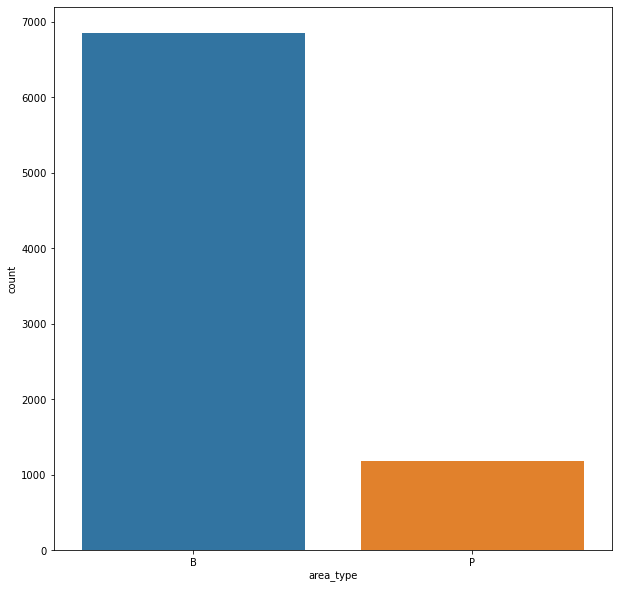

In [13]:
# visualize the target variable
plt.figure(figsize=(10, 10))
g = sns.countplot(train['area_type'])
g.set_xticklabels(['B','P'])
plt.show()

<p>
As we can see the classes are imbalanced, therefor  a classification model<br>
won't be able to learn propertly how to classify correctly the minority class 'P'.<br>
there are some ways to handle situation like this.<br>
like:<br>
<ol>
    <li>Random under-sampling</li>
    <li>Random over-sampling</li>
    <li>Under-sampling: Tomek links</li>
    <li>Synthetic Minority Oversampling Technique (SMOTE)</li>
    <li>NearMiss</li>
</ol>
we chose to use SMOTE in oreder to avoid:<br>
<ul>
<li>losing potentially useful information which could be important for building rule classifiers.</li>
<li>biased samples</li>
</ul>
and also in order to minimaize likelihood of overfitting(by not using simple Random over-sampling).</p>

<h2>The Gain</h2>
<p>By using SMOTE  we gave our classifiers more samples to learn how to predict P samples better.<br>
We mannaged to increase the specitifity(in our case true prediction of P from all P samples) by up to 20%</p>

<h2>Dealing with imbalanced data classes</h2>

Original dataset shape Counter({'B': 6856, 'P': 1184})
Resample dataset shape Counter({'B': 6856, 'P': 6856})


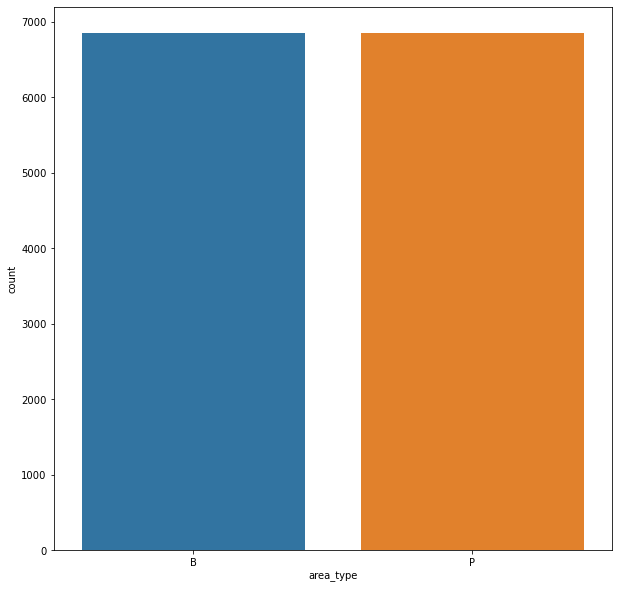

In [14]:
#########Dealing with imbalanced data classes

x = train.iloc[:,2:]
y = train.iloc[:, 1]
smote = SMOTE(random_state= RSEED)
# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(x, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

new_Train = pd.concat([y_smote, x_smote], axis=1)

# visualize the target variable
plt.figure(figsize=(10, 10))
g = sns.countplot(new_Train['area_type'])
g.set_xticklabels(['B','P'])
plt.show()


In [15]:
new_Train.head()

,area_type,availability,bedrooms,total_sqft,bath,balcony,ranked,price in rupees
0,B,1,3.000000,1655.000000,3.000000,1.000000,134,10800000.000000
1,B,1,2.000000,1102.000000,2.000000,1.000000,134,4800000.000000
2,B,0,2.000000,1112.000000,2.000000,1.000000,242,8800000.000000
3,B,1,3.000000,1450.000000,3.000000,3.000000,335,5100000.000000
4,B,1,2.000000,1010.000000,2.000000,1.000000,261,4100000.000000


In [16]:
new_Train.tail()

,area_type,availability,bedrooms,total_sqft,bath,balcony,ranked,price in rupees
13707,P,1,5.383395,725.888977,4.000000,2.000000,306,8500000.000000
13708,P,0,2.953881,1204.611898,2.953881,1.046119,165,9500000.000000
13709,P,1,4.446378,1200.000000,4.446378,2.184541,247,13500000.000000
13710,P,1,4.460821,6004.756360,5.692786,1.000000,12,70000000.000000
13711,P,1,6.606387,1534.840321,6.141850,1.070925,213,15000000.000000


<h2>Checking for connections and patterns between the features and the labels</h2>
<h3>Availability on Area type</h3>

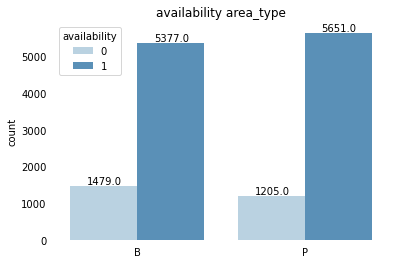

In [17]:
ax = sns.countplot(x=new_Train['area_type'], hue=new_Train['availability'], palette='Blues', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('availability' + ' area_type')
plt.ylabel('count')

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

<p>we can see that about 17.5% from all P samples have  availability  0 and <br>
about 21% from all B samples have  availability  0 <br>
this means that the availability of most samples is 1</p>

<h2>Checking the distribution of the Y label for our regression module</h2>

<Figure size 2160x2880 with 0 Axes>

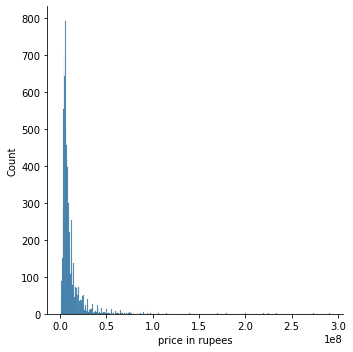

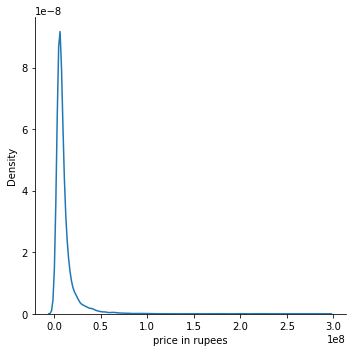

In [18]:
plt.figure(figsize=(30, 40))
sns.displot(data=regressor_train_y, x="price in rupees")
sns.displot(data=regressor_train_y, x="price in rupees", kind="kde")

<h2>Handling skewed Data</h2>

<p>As we can see our Y label is very skewed, this is a problem because the model will be trained on a much larger number of<br> moderately priced homes, and will be less likely to successfully predict<br>
 the price for the most expensive houses.<br>
 we will try to transform as best as we can the distribution to Normal distribution in order to<br>
 train our module as best as we can.<br>
 there are some ways to make this like:<br>
<ol>
<li>Square Root Transformation</li>
<li>Reciprocal Transformation</li>
<li>Log Transformation</li>
</ol>
we will try them and se which one fits the most.
</p>

<h2>The Gain</h2>
<p>by normalize the price collumn we reduced the variance of the feature<br>
and helped the regressors modules to be trained on a much larger number of expensive houses<br>
and will be much more likely to successfully predict them.<br>
</p>

<h3>Square Root Transformation</h3>

<Figure size 2160x2880 with 0 Axes>

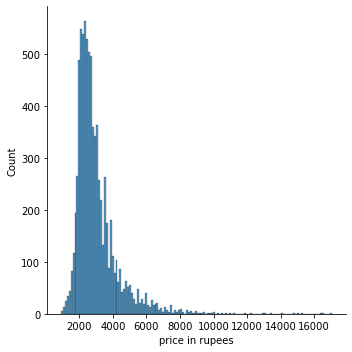

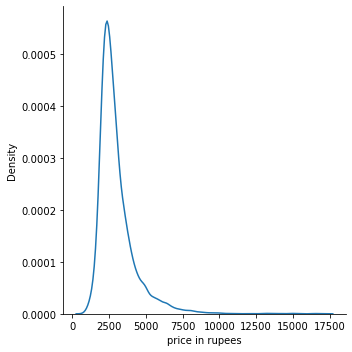

In [19]:
sqrt_resp = regressor_train_y**(0.5)
plt.figure(figsize=(30, 40))
sns.displot(data=sqrt_resp, x="price in rupees")
sns.displot(data=sqrt_resp, x="price in rupees", kind="kde")

<h3>Reciprocal Transformation</h3>

<Figure size 2160x2880 with 0 Axes>

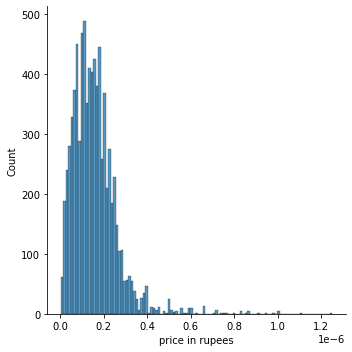

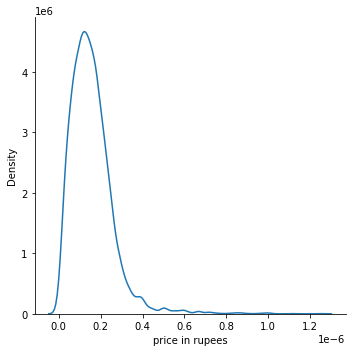

In [20]:
recip = 1/regressor_train_y
plt.figure(figsize=(30, 40))
sns.displot(data=recip, x="price in rupees")
sns.displot(data=recip, x="price in rupees", kind="kde")

<h3>Log Transformation</h3>

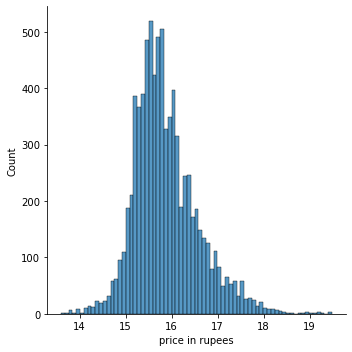

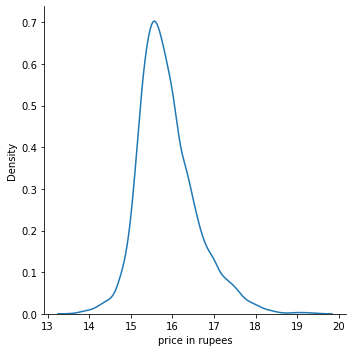

In [21]:
log_resp = np.log(regressor_train_y)
sns.displot(data=log_resp, x="price in rupees")
sns.displot(data=log_resp, x="price in rupees", kind="kde")

<p>As we can see Log Transformation perfomed the best, there for we will choose it. </p>

In [22]:
regressor_train_y = log_resp
#replace price in rupees original values with normalize ones
regressor_new_train['price in rupees'] = regressor_train_y

regressor_train_y['price in rupees'].describe()

count   8040.000000
mean      15.876632
std        0.698704
min       13.592367
25%       15.414898
50%       15.761421
75%       16.257858
max       19.489521
Name: price in rupees, dtype: float64

In [23]:
regressor_new_train.head()

,area_type,availability,bedrooms,total_sqft,bath,balcony,ranked,price in rupees
0,1,1,3.000000,1655.000000,3.000000,1.000000,134,16.195057
1,1,1,2.000000,1102.000000,2.000000,1.000000,134,15.384126
2,1,0,2.000000,1112.000000,2.000000,1.000000,242,15.990262
3,1,1,3.000000,1450.000000,3.000000,3.000000,335,15.444751
4,1,1,2.000000,1010.000000,2.000000,1.000000,261,15.226498


<h2>Adding Residual column for the train dataset(Gradiant Boosting)

In [24]:
gradiant_train = regressor_new_train.copy(deep=True)
gradiant_train['residual'] = 0
gradiant_train['prediction'] = 0
gradiant_train.head()

,area_type,availability,bedrooms,total_sqft,bath,balcony,ranked,price in rupees,residual,prediction
0,1,1,3.000000,1655.000000,3.000000,1.000000,134,16.195057,0,0
1,1,1,2.000000,1102.000000,2.000000,1.000000,134,15.384126,0,0
2,1,0,2.000000,1112.000000,2.000000,1.000000,242,15.990262,0,0
3,1,1,3.000000,1450.000000,3.000000,3.000000,335,15.444751,0,0
4,1,1,2.000000,1010.000000,2.000000,1.000000,261,15.226498,0,0


<h2>Adding columns for the train dataset(for AdaBoost)</h2>

<p>sample weight column and correct/incorrect(1,0) prediction label</p>

In [25]:
#########giving sample weight column and correct/incorrect prediction label for the train dataset(for AdaBoost)
ada_train_Set = new_Train.copy(deep=True)
ada_train_Set['sample_weight'] = None
ada_train_Set['correct'] = None
ada_train_Set = ada_train_Set.assign(sample_weight = 1/len(new_Train))
pd.set_option('display.float_format', lambda x: '%.6f' % x)
ada_train_Set.head()

,area_type,availability,bedrooms,total_sqft,bath,balcony,ranked,price in rupees,sample_weight,correct
0,B,1,3.000000,1655.000000,3.000000,1.000000,134,10800000.000000,0.000073,None
1,B,1,2.000000,1102.000000,2.000000,1.000000,134,4800000.000000,0.000073,None
2,B,0,2.000000,1112.000000,2.000000,1.000000,242,8800000.000000,0.000073,None
3,B,1,3.000000,1450.000000,3.000000,3.000000,335,5100000.000000,0.000073,None
4,B,1,2.000000,1010.000000,2.000000,1.000000,261,4100000.000000,0.000073,None


<h1 id="Section A">Section A(Coding)</h1>

<p>Our implementation for Decision Tree (classifier and regressor) algorithm<br>
and an AdaBoost (classifier) algorithm<br></p>


<h2>Classify Tree Node</h2>

<p>
we chose to use gini as a metric to feature split impurity.<br>
let P be num of class 1 and B be num class 2 in a given node after split so:<br><br>
$\large Gini = 1 - (\dfrac{P}{P+B})^2 - (\dfrac{B}{P+B})^2$<br><br>
let GL be the Gini of left node and GR  be the Gini of the right Node <br>
and NL be the num of samples in the left node and NR be the num of samples in the right node so: <br><br>
$\large Total\hspace{0.1cm}Gini = (\dfrac{NL}{NL+NR})*GL + (\dfrac{NR}{NL+NR})*GR$<br><br>

The lower the value the better the value of the feature for the split.(range from 0 -> 1).<br>
</p>

In [26]:
class ClassifyTreeNode:

    #init treenode
    def __init__(self, info, node_depth, left = None, right = None):
        #dataframe of the node
        self.info = info
        self.info_vals = self.info.values
        #node left son
        self.left = left

        #node right son
        self.right = right

        #node depth
        self.depth = node_depth

        #initilaize best split feature name and value and gini
        self.split_feat_name = ""
        self.split_feat_val = 0
        #gini for splitting(calculated in choose_split_feat_val)
        self.gini_score = 1
        #the gini score of the node
        self.gini_self = self.calc_gini_node(self.info_vals)
        #is a leaf
        self.is_leaf = False

        #predicted class(if node is leaf)
        self.predicted_Class = ""

        #a dictionary with numeric features as key and avg of adjacent values
        self.features_avg_dict = {}


    #print treenode
    def __str__(self):
        return str("\nfeature name:\n" +  str(self.split_feat_name) + "\nfeature val:\n" + str(self.split_feat_val) + "\npredicted class:\n" + str(self.predicted_Class))

    #count num of samples of any class in this node
    def count_class_num(self,data):
        label_column = data[:, classify_y]
        _,counts = np.unique(label_column, return_counts=True)
        #counts[0] = B counts[1] = P 
        if len(counts) == 2:
            return counts[0], counts[1]
        elif len(counts) == 1:
            if _[0] == classes[0]:
                return counts[0], 0
            else:
                return 0 , counts[0]
        return 0, 0

    #count num of total samples in the node
    def count_total_num(self,data):
        return len(data)

    #calc gini value of the node
    def calc_gini_node(self, data):
        b_num, p_num = self.count_class_num(data)
        #if node is empty
        if b_num == 0 and p_num == 0:
            return 1
        #else
        probabilities_b = b_num/(b_num+ p_num)
        probabilities_p = p_num/(b_num+ p_num)
        return 1 - np.power(probabilities_b, 2) - np.power(probabilities_p, 2)

    #calc gini score for each feature
    #select the best feature and its value for splitting the node based on the
    #best gini score's of all the values if each feature
    def calc_gini_score_for_all(self):

        self.calc_feat_avg()
        min_gini = 1
        feat_val = 0
        feat_index = -1
        feat_gini = 1
        #if feature is categorical
        for f in categoricals_list:
            node = self
            right, left = self.split_data_categorial(self.info_vals,f,1)
            feat_gini = self.calc_gini_split(node, left, right)
            feat_index = f
            feat_val = 1
            if feat_gini < min_gini and feat_gini < self.gini_self:
                self.split_feat_name = feat_index
                self.split_feat_val = feat_val
                self.gini_score = feat_gini
                min_gini = feat_gini
        #if feature is numeric
        for f in numeric_list:
            node = self
            for feat_val in self.features_avg_dict[f]:
                right, left = self.split_data_numeric(self.info_vals,f,feat_val)
                feat_gini = self.calc_gini_split(node, left, right)
                feat_index = f
                feat_numeric_val = feat_val
                if feat_gini < min_gini and feat_gini < self.gini_self:
                    self.split_feat_name = feat_index
                    self.split_feat_val = feat_numeric_val
                    self.gini_score = feat_gini
                    min_gini = feat_gini

    # calc gini score
    def calc_gini_split(self, node, left, right):
        All = node.count_total_num(node.info_vals)
        left_num = node.count_total_num(left)
        right_num = All - left_num

        return (left_num / All) * node.calc_gini_node(left) + (right_num / All) * node.calc_gini_node(right)

    #calc avg of adjacent values of each feature
    def calc_feat_avg(self):
        length = len(numeric_list)
        for i in range(0, length):
            avg_set = []
            info_arr = self.info.values
            vals = info_arr[:,numeric_list[i]]
            valsSet = np.unique(vals)
            arr_size = valsSet.size
            for j in range(0, arr_size - 1):
                avg_set.append((valsSet[j] + valsSet[j + 1]) / 2)
            self.features_avg_dict[numeric_list[i]] = avg_set


    #split data based on chosen feature and value
    #and return the 2 new dataframes
    def split_data_numeric(self, data, feature_index, split_value):
        split_column_values = data[:, feature_index]
        right = data[split_column_values <= split_value]
        left = data[split_column_values > split_value]
        return right,left

    def split_data_categorial(self, data, feature_index, split_value):
        split_column_values = data[:, feature_index]
        right = data[split_column_values != split_value]
        left = data[split_column_values == split_value]
        return right,left

<h2>Regression node</h2>

<p>
we chose to use SSR as our way to evaluate the split quality of a feature in a regression modules.<br>
let N be num of the testing samples, Y the true value of the Y label and $\hat{Y}$ be our prediction value for a certain sample, therefor:<br><br>
$\large SSR = \sum_{n=0}^{N} (Y- \hat{Y})^2$<br><br>
The lower the value the better the value of the feature for the split.
</p>

In [27]:
class RegressionTreeNode:

    #init the node
    def __init__(self, info, node_depth, ylabel, left = None, right = None):
        #dataframe of the node
        self.info = info
        self.info_vals = self.info.to_numpy()

        #node left son
        self.left = left

        #node right son
        self.right = right

        #node depth
        self.depth = node_depth

        self.regressor_y = ylabel
        #initilaize best split feature name and value and SSR
        self.split_feat_name = ""
        self.split_feat_val = 0
        #SSR for splitting(calculated in choose_split_feat_val)
        self.SSR_score = 1
        #predicted value(if node is leaf)
        self.predicted_value = np.mean(self.info_vals[:,self.regressor_y])

        #is a leaf
        self.is_leaf = False

        #a dictionary with numeric features as key and avg of adjacent values
        self.features_avg_dict = dict()

    #print tree node
    def __str__(self):
        return str("\nfeature name:\n" +  str(self.split_feat_name) + "\nfeature val:\n" + str(self.split_feat_val) + "\npredicted value:\n" + str(self.predicted_value))

    #calc the SSR of a given node
    def calc_SSR(self,data):

        sum = 0
        mean = np.mean(data[:,self.regressor_y])
        for i in data:
            sum +=(i[self.regressor_y] - mean)**2
        return sum

    #calc avg of adjacent values of each feature
    def calc_feat_avg(self):

        lenght = len(reg_numeric_list)
        for i in range(0, lenght):
            avg_set = []
            info_arr = self.info_vals
            vals = info_arr[:,reg_numeric_list[i]]
            valsSet = np.unique(vals)
            arr_size = valsSet.size
            for j in range(0, arr_size - 1):
                avg_set.append((valsSet[j] + valsSet[j + 1]) / 2)
            self.features_avg_dict[reg_numeric_list[i]] = avg_set

    #calc SSR score for each feature
    #select the best feature and its value for splitting the node based on the
    #best SSR score's of all the values of each feature
    def calc_SSR_score_for_all(self):

        self.calc_feat_avg()
        min_ssr = float('inf')
        feat_val = 0
        feat_name = ""
        feat_ssr = float('inf')
        #if feature is categorical
        for f in reg_categoricals_list:
            node = self
            right, left = self.split_data_categorial(self.info_vals,f,1)
            feat_name = f
            feat_val = 1
            feat_ssr = node.calc_SSR(left) + node.calc_SSR(right)
            if feat_ssr < min_ssr:
                self.split_feat_name = feat_name
                self.split_feat_val = feat_val
                self.SSR_score = feat_ssr
                min_ssr = feat_ssr
        #if feature is numeric
        for f in reg_numeric_list:
            node = self
            for feat_avg_val in self.features_avg_dict[f]:
                right, left = self.split_data_numeric(self.info_vals,f,feat_avg_val)
                feat_ssr = node.calc_SSR(left) + node.calc_SSR(right)
                if feat_ssr < min_ssr:
                    self.split_feat_name = f
                    self.split_feat_val = feat_avg_val
                    self.SSR_score = feat_ssr
                    min_ssr = feat_ssr

    #split data based on chosen feature and value
    #and return the 2 new dataframes
    def split_data_numeric(self, data, feature_index, split_value):
        split_column_values = data[:, feature_index]
        right = data[split_column_values <= split_value]
        left = data[split_column_values > split_value]
        return right,left

    #split_value = 1(default)
    def split_data_categorial(self, data, feature_index, split_value):
        split_column_values = data[:, feature_index]
        right = data[split_column_values != split_value]
        left = data[split_column_values == split_value]
        return right,left

<h2>Classify Tree</h2>

In [28]:
class ClassifyTree:

    #init ClassifyTree
    def __init__(self, info,classify_max_depth,classify_min_samples):
        #root of the tree
        self.root = ClassifyTreeNode(info,0,None,None)

        #max depth of the tree
        self.max_depth = classify_max_depth

        #min samples per node
        self.min_samples = classify_min_samples

    #spliting the node to 2 dataset based on the selected feature
    def split(self,node):
        try:
            node.calc_gini_score_for_all()
        except IndexError:
            self.set_leaf_vals(node)
            return
        if node.gini_self > node.gini_score:
            if node.split_feat_name in  categoricals_list:
                left_info = node.info.loc[node.info_vals[:,node.split_feat_name] == node.split_feat_val]
                right_info = node.info.loc[node.info_vals[:,node.split_feat_name] != node.split_feat_val]
            else:
                left_info = node.info.loc[node.info_vals[:,node.split_feat_name] >= node.split_feat_val]
                right_info = node.info.loc[node.info_vals[:,node.split_feat_name] < node.split_feat_val]
            node.left = ClassifyTreeNode(left_info, node.depth + 1, None, None)
            node.right = ClassifyTreeNode(right_info, node.depth + 1, None, None)

    #by a given node return true if we should continue splitting the node based on the hyper parameters
    #otherwise return false
    def to_split(self,node):

        total_num = 0
        #check if node is pure
        b_class , p_class = node.count_class_num(node.info_vals)
        if b_class == 0 or p_class == 0 :
                return False
        else:
            total_num = b_class + p_class
        #check hyper params
        if total_num >= self.min_samples and node.depth < self.max_depth:
            return True
        return False

    #setting values of a leaf
    def set_leaf_vals(self, node):
        node.is_leaf = True
        class_a , class_b= node.count_class_num(node.info_vals)
        node.predicted_Class = classes[0] if class_a >= class_b else classes[1]

    #build the tree
    def build(self,node):
        if node is not None:
            if self.to_split(node):
                self.split(node)
                if node.left is not None and node.right is not None:
                    self.build(node.left)
                    self.build(node.right)
            else:
                self.set_leaf_vals(node)

    #predict a class of a given sample
    def predict(self,node,sample):
        if node is not None and sample is not None:
            if not node.is_leaf:
                if sample[node.split_feat_name] >= node.split_feat_val:
                    return self.predict(node.left,sample)
                else:
                    return self.predict(node.right,sample)
            else:
                return node.predicted_Class

<h2>Regression Tree</h2>

In [29]:
class RegressionTree:

    #init ClassifyTree
    def __init__(self, info,max_tree_depth,leaf_min_samples,ylabel):
        #root of the tree
        self.root = RegressionTreeNode(info,0,ylabel,None,None)

        #max depth of the tree
        self.max_depth = max_tree_depth

        #min samples per node
        self.min_samples = leaf_min_samples

        #the feature we want to predict its value
        self.regressor_y = ylabel

    #spliting the node to 2 dataset based on the selected feature
    def split(self,node):

        node.calc_SSR_score_for_all()

        if node.split_feat_name in  reg_categoricals_list:
            left_info = node.info.loc[node.info_vals[:,node.split_feat_name] == node.split_feat_val]
            right_info = node.info.loc[node.info_vals[:,node.split_feat_name] != node.split_feat_val]
        else:
            left_info = node.info.loc[node.info_vals[:,node.split_feat_name] >= node.split_feat_val]
            right_info = node.info.loc[node.info_vals[:,node.split_feat_name] < node.split_feat_val]
        node.left = RegressionTreeNode(left_info, node.depth + 1,self.regressor_y, None, None)
        node.right = RegressionTreeNode(right_info, node.depth + 1,self.regressor_y, None, None)

    #by a given node return true if we should continue splitting the node based on the hyper parameters
    #otherwise return false
    def to_split(self,node):
        #check hyper params
        if len(node.info) >= self.min_samples and node.depth < self.max_depth:
            return True
        return False

    #setting values of a leaf
    def set_leaf_vals(self, node):
        node.is_leaf = True

    #build the tree
    def build(self,node):
        if node is not None:
            if self.to_split(node):
                self.split(node)
                if node.left is not None and node.right is not None:
                    self.build(node.left)
                    self.build(node.right)
            else:
                self.set_leaf_vals(node)

    #predict a house price of a given sample
    #node is the root at the first call to this function
    def predict(self,node,sample):
        if node is not None and sample is not None:
            if not node.is_leaf:
                if sample[node.split_feat_name] >= node.split_feat_val:
                    return self.predict(node.left,sample)
                else:
                    return self.predict(node.right,sample)
            else:
                return node.predicted_value

<h2>Stump</h2>

In [30]:
class Stump:

    def __init__(self,data):

        #sum of weights of all misclassified samples
        self.total_error = 0

        #weight of the stump
        self.stump_weight = 0

        #stump root
        self.root = ClassifyTreeNode(data,0,None,None)

    #split the data based on the calculated best feature and its val
    def split(self):

        #find best split feature and val for split
        self.root.calc_gini_score_for_all()

        if self.root.gini_self > self.root.gini_score:
            #spliting the data frame
            if self.root.split_feat_name in  categoricals_list:
                left_info = self.root.info.loc[self.root.info_vals[:,self.root.split_feat_name] == self.root.split_feat_val]
                right_info = self.root.info.loc[self.root.info_vals[:,self.root.split_feat_name] != self.root.split_feat_val]
            else:
                left_info = self.root.info.loc[self.root.info_vals[:,self.root.split_feat_name] >= self.root.split_feat_val]
                right_info = self.root.info.loc[self.root.info_vals[:,self.root.split_feat_name] < self.root.split_feat_val]

            #creating children
            self.root.left = ClassifyTreeNode(left_info, self.root.depth + 1, None, None)
            self.root.right = ClassifyTreeNode(right_info, self.root.depth + 1, None, None)

            #setting leaf values
            self.set_leaf_vals(self.root.left)
            self.set_leaf_vals(self.root.right)

    #setting values of a leaf
    def set_leaf_vals(self, node):

        node.is_leaf = True
        class_a , class_b= node.count_class_num(node.info_vals)
        node.predicted_Class = classes[0] if class_a > class_b else classes[1]

    #predicting sample class
    def predict(self, sample):

        #self.root.split_feat_name != "" refers to the case that the gini score of the selected feature is higher
        #from the gini of the node there for we did not split the node
        #or if the root node is pure
        #reference to this if statment in function calc gini score for all in classify tree node:
        #feat_gini < min_gini and feat_gini < self.gini_self
        if sample is not None and self.root.split_feat_name != "":
            if sample[self.root.split_feat_name] >= self.root.split_feat_val:
                return self.root.left.predicted_Class
            else:
                return self.root.right.predicted_Class

        #in case all samples in the stump data belong to the same class or if we did not split the node
        else:
            class_a , class_b= self.root.count_class_num(self.root.info_vals)
            return class_a if class_a > class_b  else  class_b

    #calc total error
    def calc_total_error(self, data):

         for i in range(0,len(data.index)):
            prediction = self.predict(data.iloc[i])
            if data.iloc[i][classify_y] == prediction:
                data.iat[i, 9] = 1
            else:
                data.iat[i, 9] = 0
                self.total_error += data.iloc[i]['sample_weight']

    #calc weight of the stump
    def calc_stump_weight(self):
        #the log formula for calculating the stump weight cannot get total error of 1 or 0
        #edge case that the stump classified correctly all the samples
        if self.total_error <= 0:
            self.total_error = 0.000073
        #edge case that the stump classified incorrectly all the samples
        elif self.total_error >= 1:
            self.total_error = 0.99
        self.stump_weight = 0.5*math.log((1 - self.total_error)/self.total_error)

<h2>AdaBoost</h2>

In [31]:
class AdaBoost:

    def __init__(self, data, estimators_num):

        #array for storing the stumps
        self.stump_arr = np.array([])

        #train data
        self.data = data

        #num of stumps we want to create
        self.n_estimators =  estimators_num


    #create all the estimators
    def fit(self):

        stump_data = self.data
        for i in range(0,self.n_estimators):
            self.create_stump(stump_data)
            self.evaluate_stump(i)
            self.data = self.update_weights(self.data,i)
            ranges_list = self.arrange_by_ranges(self.data)
            stump_data = self.create_dataset(ranges_list)

    #predict class of a given sample
    def  predict(self,sample):

        class_a = 0
        class_b = 0
        for i in range(0,self.n_estimators):
            prediction = self.stump_arr[i].predict(sample)

            if prediction == classes[0]:
                class_a += self.stump_arr[i].stump_weight
            else:
                class_b += self.stump_arr[i].stump_weight
        if class_a > class_b:
            return classes[0]
        return classes[1]

    #create a new dataset based on the new weights
    def create_dataset(self, data):

        new_dataset = pd.DataFrame()
        data_len = len(self.data.index)

        for i in range(0,data_len):
            rand_float = random.uniform(0, 1)
            index = self.ranges_binary_search(data,rand_float,0,len(data))
            new_dataset = new_dataset.append(self.data.iloc[index])

        return new_dataset

    #create a stump and add it to the stump array
    def create_stump(self,data):

        stump = Stump(data)
        stump.split()
        self.stump_arr = numpy.append(self.stump_arr, stump)

    #evaluate a given stump
    def evaluate_stump(self,stump_index):

        self.stump_arr[stump_index].calc_total_error(self.data)
        self.stump_arr[stump_index].calc_stump_weight()


    #calc new weights for samples based on prediction of a stump and return the updated dataframe
    def update_weights(self,data,stump_index):

        weights_sum = 0
        for i in range(0,len(data.index)):

            #decrease weight of correctly classified samples
            if data.iloc[i]['correct'] == 1:
                data.iat[i, 8] = data.iloc[i]['sample_weight'] *(e ** ( - self.stump_arr[stump_index].stump_weight ))
            #increase weight of incorrectly classified samples
            else:
                data.iat[i, 8] = data.iloc[i]['sample_weight'] *(e ** self.stump_arr[stump_index].stump_weight)

            weights_sum += data.iloc[i]['sample_weight']

        #normilaize weights
        for i in range(0,len(data.index)):
             data.iat[i, 8] = data.iloc[i]['sample_weight']/weights_sum

        return data


    #arrange samples ranges in an array
    def arrange_by_ranges(self, data):

        ranges_list = list()
        ranges = 0

        for i in range(0,len(data.index)):
            before = ranges
            ranges += data.iloc[i]['sample_weight']
            to_insert = [before,ranges]
            ranges_list.append(to_insert)

        return ranges_list


    #return the index of the  range which k is between
    def ranges_binary_search(self,rang_list,k,start,end):

        #stop condition(not suppose to happen)
        if start > end:
            return -1

        #edge case
        if k == 0:
            return 0

        mid = int((end+start)/2)

        #rang_list[mid][0] = start of the sample range in the mid-index of  the #ranges_list
        #rang_list[mid][1] = end of the sample range in the mid-index of  the #ranges_list
        if rang_list[mid][0] < k <= rang_list[mid][1]:
            return mid

        elif rang_list[mid][1] < k:
            return  self.ranges_binary_search(rang_list,k,mid + 1,end)

        return self.ranges_binary_search(rang_list,k,start,mid - 1)

<h2>Gradiant Boost(Section D1)</h2>

In [32]:
class GradiantBoost:

    def __init__(self,data,learing_rate,grad_max_depth,estimators_num, ylabel,residual_label,yname,grad_min_samples,prediction_index):

        #train dataframe
        self.data = data

        #max depth of a tree
        self.max_depth = grad_max_depth

        #learnig rate
        self.learing_rate = learing_rate

        #min samples for split
        self.grad_min_samples = grad_min_samples

        #num of estimatores
        self.estimators = estimators_num

        #index of the y label
        self.regressor_y = ylabel

        #residial label index
        self.residual = residual_label

        #y label name(for dataframe.loc function)
        self.y_name = yname

        #index of the prediction collumn of each sample
        self.prediction_index = prediction_index

        #array of estimators
        self.estimators_arr = np.array([])

        #initial predicted value
        self.initial_value = self.data.iloc[:,self.regressor_y].values.mean()

        self.data = self.data.assign(residual = self.data[self.y_name] - self.initial_value)
        self.data = self.data.assign(prediction = self.initial_value)

    #create a new tree
    def create_tree(self):
        reg_tree = RegressionTree(self.data,self.max_depth,self.grad_min_samples,self.residual)
        reg_tree.build(reg_tree.root)
        self.estimators_arr = numpy.append(self.estimators_arr, reg_tree)

    #update residual after creating a new tree
    def update_residuals(self,index):

        for row in range(0,len(self.data)):
            predict = self.estimators_arr[index].predict(self.estimators_arr[index].root,self.data.iloc[row])
            self.data.iat[row, self.prediction_index] = self.data.iloc[row][self.prediction_index] + predict * self.learing_rate
            self.data.iat[row,self.residual] = self.data.iloc[row][regressor_y] - (self.data.iloc[row][self.prediction_index])
            
    #building the module
    def fit(self):

        for i in range(0,self.estimators):
            self.create_tree()#create a new tree and add it to the estimators array
            self.update_residuals(i)#update the residuals of the samples

    #predict a house price of a given sample
    def predict(self,sample):

        prediction = 0
        for i in self.estimators_arr:
                predict = i.predict(i.root,sample)
                prediction += predict * self.learing_rate
        return self.initial_value + prediction

<h1>main section</h1>
<span id="Section B"></span>

<h2>Building the classify tree</h2>

In [41]:
#building the module
print("---starting classify tree grid search....")
classify_tree = classify_grid_search(new_Train,validation,max_depth,min_samples)
print("---ended classify tree grid search....")

---starting classify tree grid search....
building classify tree started...
building classify tree ended in 178.02604937553406 seconds
building classify tree started...
building classify tree ended in 177.89148831367493 seconds
building classify tree started...
building classify tree ended in 218.3826401233673 seconds
building classify tree started...
building classify tree ended in 218.08837914466858 seconds
---ended classify tree grid search....


<h2>predicting and evaluating the module</h2>


In [42]:
#predicting

#selected hyperparameters
selected_params = {"max_depth:":classify_tree.max_depth,"min samples for split:":classify_tree.min_samples}
print(pd.DataFrame(data=selected_params, index=['selected']))

classify_test = test.copy(deep=True)
classify_test = classify_test.drop(['Unnamed: 0'], axis=1)
print("predicting")
eval = Evaluation()
eval.predicting(classify_test,classify_tree)

#evaluating
eval_Df = {"TRUE B": eval.TA, "TRUE P": eval.TB, "FALSE B": eval.FA, "FALSE P":eval.FB}
print(pd.DataFrame(data=eval_Df, index=['count']))
eval_Df = {"accuracy": eval.accuracy, "sensitivity": eval.sensitivity, "specificity": eval.specificity, "precision":eval.precision}
pd.DataFrame(data=eval_Df, index=['value'])

          max_depth:  min samples for split:
selected           7                       4
predicting
       TRUE B  TRUE P  FALSE B  FALSE P
count    2037     254       96      126


,accuracy,sensitivity,specificity,precision
value,0.912,0.942,0.726,0.955


<h2>Building the Regression tree</h2>

In [33]:
#building the module
print("---started regression tree grid_search....")
regtree = reg_grid_search(regressor_new_train, validation, reg_max_depth, reg_min_samples)
print("---ended regression tree grid_search....")

---started regression tree grid_search....
building regression tree started...
building regression tree ended in 25.255584478378296 seconds
building regression tree started...
building regression tree ended in 25.287410497665405 seconds
building regression tree started...
building regression tree ended in 25.356464624404907 seconds
building regression tree started...
building regression tree ended in 25.147783517837524 seconds
---ended regression tree grid_search....


<h2>predicting and evaluating the module</h2>

In [34]:
from sklearn.metrics import r2_score

#predicting
eval = Reg_Evaluation()

#selected hyperparameters
selected_params = {"max_depth:":regtree.max_depth,"min samples for split:":regtree.min_samples}
print(pd.DataFrame(data=selected_params, index=['selected']))

#pre-processing the test data(changing categorical values)
regressor_test_area_type = test['area_type'].map({'B': 1, 'P': 0})
regressor_test = pd.concat([regressor_test_area_type, test.iloc[:,2:]], axis=1)

#predicting
pred = eval.predicting_regression(regressor_test, regtree)

#evaluating
pd.set_option('display.float_format', lambda x: '%.3f' % x)



MSE = round(mean_squared_error(test.iloc[:,8:], pred), 3)
R2 = r2_score(test.iloc[:,8:], pred)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df = pd.DataFrame([MSE,R2]).T
df = df.rename(index={0: 'Decision Tree Regressor'}, columns={0: 'MSE',1:'R^2'})
print(df)

          max_depth:  min samples for split:
selected           8                      20
                                       MSE   R^2
Decision Tree Regressor 46500608901924.867 0.607


<h2>Building the AdaBoost Classifier</h2>

In [68]:
#building the module
print("---building AdaBoost Classifier started....")
start_time = time.time()
adaboost = adaboost_grid_search(ada_train_Set,validation,n_estimators)
print("---building AdaBoost Classifier ended in %s seconds...." % (time.time() - start_time))

---building AdaBoost Classifier started....
---building AdaBoost Classifier ended in 7174.536885023117 seconds....


<h2>predicting and evaluating the module</h2>

In [70]:
#predictiong and evaluating
print("predicting")
classify_test = test.copy(deep=True)
classify_test = classify_test.drop(['Unnamed: 0'], axis=1)
eval = AdaEvaluation()
eval.predicting_adaboost(classify_test, adaboost)
#evaluating
eval_Df = {"TRUE B": eval.TA, "TRUE P": eval.TB, "FALSE B": eval.FA, "FALSE P":eval.FB}
print(pd.DataFrame(data=eval_Df, index=["count"]))
eval_Df = {"accuracy": eval.accuracy, "sensitivity": eval.sensitivity, "specificity": eval.specificity, "precision":eval.precision}
pd.DataFrame(data=eval_Df, index=["value"])

predicting
       TRUE B  TRUE P  FALSE B  FALSE P
count    1941     253       97      222


,accuracy,sensitivity,specificity,precision
value,0.873,0.897,0.723,0.952


<h2>building the Gradiant Boost(Section D1) </h2>


In [35]:
print("started gradiant boost grid search...")
g = gradiant_grid_search(gradiant_train,validation,gradiant_max_depth,gradiant_estimators,0.5)
print("ended gradiant boost grid search...")

started gradiant boost grid search...
building gradiant boost started...
building gradiant boost ended in 247.13996124267578 seconds
building gradiant boost started...
building gradiant boost ended in 530.1908087730408 seconds
building gradiant boost started...
building gradiant boost ended in 273.22786712646484 seconds
building gradiant boost started...
building gradiant boost ended in 616.2974944114685 seconds
ended gradiant boost grid search...


In [36]:
eval = GradiantEvaluation()

#selected hyperparameters
selected_params = {"max_depth:":g.max_depth,"estimators num:":g.estimators}
print(pd.DataFrame(data=selected_params, index=['selected']))

#pre-processing the test data(changing categorical values)
regressor_test_area_type = test['area_type'].map({'B': 1, 'P': 0})
regressor_test = pd.concat([regressor_test_area_type, test.iloc[:,2:]], axis=1)

#predicting
pred = eval.predicting_gradiant(regressor_test, g)
#evaluating
pd.set_option('display.float_format', lambda x: '%.3f' % x)

MSE = round(mean_squared_error(test.iloc[:,8:], pred), 3)
R2 = r2_score(test.iloc[:,8:], pred)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df = pd.DataFrame([MSE,R2]).T
df = df.rename(index={0: 'Decision Tree Regressor'}, columns={0: 'MSE',1:'R^2'})
print(df)

          max_depth:  estimators num:
selected           5               10
                                       MSE   R^2
Decision Tree Regressor 44048656039215.648 0.628


<h1>Section c</h1>
<h2>Sclearn classify implamantion</h2>
<span id="Section C"></span>

building classify tree ended in 4.767280340194702 seconds
                max_depth  min_samples_leaf
Selected Value          7                 6
                          Accuracy
Decision Tree Classifier     0.911


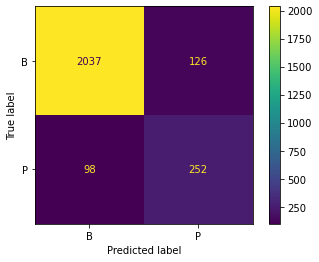

,accuracy,sensitivity,specificity,precision
0,0.911,0.942,0.720,0.954


In [37]:


##sclearn implementation
dt = DecisionTreeClassifier(random_state=RSEED)
# define parameter grid
parameters_grid = {
    'max_depth': [4, 5,6,7],
    'min_samples_leaf': [2,4,6,8],
}

# define grid search
grid_search = GridSearchCV(estimator=dt, param_grid=parameters_grid, cv=10)


# fit estimator
start_time = time.time()
grid_search.fit(x_smote, y_smote)
print("building classify tree ended in %s seconds" % (time.time() - start_time))
# get best estimator
best = grid_search.best_estimator_

# print best parameters
print(pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T)
# predict
y_pred = best.predict(test.iloc[:,2:])

#evaluating
# calculate accuracy
acc = round(accuracy_score(test.iloc[:,1:2], y_pred), 3)

df = pd.DataFrame([acc]).T
df = df.rename(index={0: 'Decision Tree Classifier'}, columns={0: 'Accuracy'})
df
print(df)

#confusion_matrix
plot_confusion_matrix(grid_search, test.iloc[:,2:], test.iloc[:,1:2])
plt.show()
tp, fn, fp, tn = confusion_matrix(test.iloc[:,1:2], y_pred).ravel()
eval_sklearn = Evaluation()
eval_sklearn.TA = tp
eval_sklearn.TB = tn
eval_sklearn.FA = fp
eval_sklearn.FB = fn
eval_sklearn.accuracy, eval_sklearn.sensitivity, eval_sklearn.specificity, eval_sklearn.precision = calcMatrics(tp,tn,fp,fn)
eval_Df = {"accuracy": eval_sklearn.accuracy, "sensitivity": eval_sklearn.sensitivity, "specificity": eval_sklearn.specificity, "precision":eval_sklearn.precision}
pd.DataFrame(data=eval_Df, index=[0])

<h2>Sclearn Adaboost implamantion</h2>

sklearn adaboost fit time 4.805155277252197 seconds ---
                n_estimators
Selected Value            20
                     Accuracy
AdaBoost Classifier     0.883


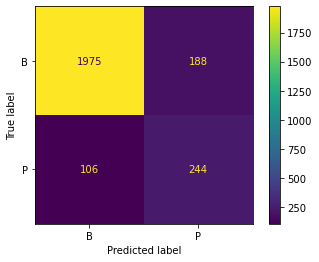

,accuracy,sensitivity,specificity,precision
0,0.883,0.913,0.697,0.949


In [38]:
# define model
ab = AdaBoostClassifier(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'n_estimators': [10,20],
}

# define grid search
grid_search = GridSearchCV(estimator=ab, param_grid=parameters_grid, cv=10)
start_time = time.time()
# fit estimator
grid_search.fit(x_smote, y_smote)
print("sklearn adaboost fit time %s seconds ---" % (time.time() - start_time))
# get best estimator
best = grid_search.best_estimator_

# print best parameters
print(pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T)

# predict
y_pred = best.predict(test.iloc[:,2:])

# calculate accuracy
acc = round(accuracy_score(test.iloc[:,1:2], y_pred), 3)

df = pd.DataFrame([acc]).T
df = df.rename(index={0: 'AdaBoost Classifier'}, columns={0: 'Accuracy'})
print(df)

#confusion_matrix
plot_confusion_matrix(grid_search, test.iloc[:,2:], test.iloc[:,1:2])
plt.show()
tp, fn, fp, tn = confusion_matrix(test.iloc[:,1:2], y_pred).ravel()
eval_sklearn = Evaluation()
eval_sklearn.TA = tp
eval_sklearn.TB = tn
eval_sklearn.FA = fp
eval_sklearn.FB = fn
eval_sklearn.accuracy, eval_sklearn.sensitivity, eval_sklearn.specificity, eval_sklearn.precision = calcMatrics(tp,tn,fp,fn)
eval_Df = {"accuracy": eval_sklearn.accuracy, "sensitivity": eval_sklearn.sensitivity, "specificity": eval_sklearn.specificity, "precision":eval_sklearn.precision}
pd.DataFrame(data=eval_Df, index=[0])

<h2>Sclearn Regression implamantion</h2>


In [39]:
# define model
dt = DecisionTreeRegressor(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'max_depth': [3, 4, 5 , 6 ,7 , 8],
    'min_samples_leaf': [20, 30,15,10,12,5,6,7,4],
}

# define grid search
grid_search = GridSearchCV(estimator=dt, param_grid=parameters_grid, cv=10)

# fit estimator
start_time = time.time()
grid_search.fit(regressor_train_X, regressor_train_y)
print("sklearn regressor fit time %s seconds ---" % (time.time() - start_time))
# get best estimator
best = grid_search.best_estimator_

# print best parameters
print(pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T)

regressor_test_area_type = test['area_type'].map({'B': 1, 'P': 0})

regressor_test = pd.concat([regressor_test_area_type, test.iloc[:,2:8]], axis=1)

# predict
y_pred = best.predict(regressor_test.iloc[:,0:8])
y_pred_after_exp = list()
for pred in y_pred:
    y_pred_after_exp.append(exp(pred))

# calculate MSE
MSE = round(mean_squared_error(test.iloc[:,8:], y_pred_after_exp), 3)
R2 = r2_score(test.iloc[:,8:], y_pred_after_exp)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df = pd.DataFrame([MSE,R2]).T
df = df.rename(index={0: 'Decision Tree Regressor'}, columns={0: 'MSE',1:'R^2'})
df

sklearn regressor fit time 5.181177139282227 seconds ---
                max_depth  min_samples_leaf
Selected Value          8                20


,MSE,R^2
Decision Tree Regressor,36565772832157.883,0.691


<h2>Sclearn Gradiant Boost(Section D1)</h2>

In [40]:
# define model
gb = GradientBoostingRegressor(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'learning_rate': [0.5, 1, 1.5],
    'n_estimators': [10, 20,30]
}

# define grid search
grid_search = GridSearchCV(estimator=gb, param_grid=parameters_grid, cv=10)

# define grid search
grid_search = GridSearchCV(estimator=gb, param_grid=parameters_grid, cv=10)

start_time = time.time()
# fit estimator
grid_search.fit(regressor_train_X, regressor_train_y)
print("sklearn gradiant boost fit time %s seconds ---" % (time.time() - start_time))

# get best estimator
best = grid_search.best_estimator_

# print best parameters
print(pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T)


regressor_test_area_type = test['area_type'].map({'B': 1, 'P': 0})

regressor_test = pd.concat([regressor_test_area_type, test.iloc[:,2:8]], axis=1)

# predict
y_pred = best.predict(regressor_test.iloc[:,0:8])
y_pred_after_exp = list()
for pred in y_pred:
    y_pred_after_exp.append(exp(pred))

MSE = round(mean_squared_error(test.iloc[:,8:], y_pred_after_exp), 3)
R2 = r2_score(test.iloc[:,8:], y_pred_after_exp)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df = pd.DataFrame([MSE,R2]).T
df = df.rename(index={0: 'Decision Tree Regressor'}, columns={0: 'MSE',1:'R^2'})
df

sklearn gradiant boost fit time 6.491684675216675 seconds ---
                learning_rate  n_estimators
Selected Value          0.500        30.000


,MSE,R^2
Decision Tree Regressor,39972929801796.953,0.662
